In [0]:
!pip install tensorflow-gpu #install tensorflow 2.0 (mandatory)

In [0]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, accuracy_score
import time

In [0]:
iris = datasets.load_iris()
x = iris.data
y = iris.target.reshape(-1, 1)

# Labels are specifically one hot encoded
# because of the weird behaviour I encountered with SparceCategoricalCrossentropy+NN backprop optimization
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)

# Split the data for training and testing
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)

In [0]:
# Adds sampled normal distribution noise to the weight matrices
def pick_neighbour(weights):
  w_array = np.array(weights[0])
  b_array = np.array(weights[1])

  # Select a neighbour model by sampling normal distribution and adding results to weights
  return [w_array+np.random.normal(size=w_array.shape),b_array+np.random.normal(size=b_array.shape)] 

# Cross entropy loss  
def iris_loss(y_pred,y_true):
 return log_loss(y_true,y_pred)

def p_star(h,T):
  return np.exp(-h/T)

# Model training using simulated annealing
def train_sa_iris(k_max = 500,annealing_rate = 0.95, decay_freq=10, min_T = 0.1):
  
  # Define neighbour and main models
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation=tf.nn.sigmoid, input_shape=(4,)), 
    tf.keras.layers.Dense(32, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  neighbour_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation=tf.nn.sigmoid, input_shape=(4,)),
    tf.keras.layers.Dense(32, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  
  #Init temperature with current model loss
  T = iris_loss(model.predict(x_train),y_train)
  
  losses = []

  start = time.time()
  for k in range(k_max):

    #Select neighbour using normal distribution
    for i,l in enumerate(model.layers):
      new_weights = pick_neighbour(l.get_weights())
      neighbour_model.get_layer(index=i).set_weights(new_weights)
    
    #Calculate losses for current and neighbour models
    preds = model.predict(x_train)
    neighbour_preds = neighbour_model.predict(x_train)
    val_preds = model.predict(x_test)

    model_loss = iris_loss(preds,y_train)
    neighbour_loss = iris_loss(neighbour_preds,y_train)
    val_loss = iris_loss(val_preds,y_test)

    #Save current loss value for visualization
    losses.append(val_loss)

    #Evaluate p* values for both models and sample value from uniform distribution 
    p_model = p_star(model_loss,T)
    p_neighbour = p_star(neighbour_loss,T)

    alpha = p_neighbour/p_model
    uniform_sample = np.random.uniform(size=1)

    # Update current model weights with neighbour's weights in case if the results improved
    # or if not do so with probability alpha
    if uniform_sample<=alpha or model_loss>neighbour_loss:
      model.set_weights(neighbour_model.get_weights())
    
    # Training parameters printing for testing
    if k%100==0:
      accuracy = accuracy_score(np.argmax(y_train,axis=1),np.argmax(preds,axis=1))
      print("K {},Accuracy: {}, Loss current:{} neighbour:{}, validation_loss {}, p_model {}, p_neighbour {}, alpha {}".format(k,accuracy,model_loss,neighbour_loss,val_loss,p_model, p_neighbour, alpha))

    # Update temperature every decay_freq iterations
    if k%decay_freq==0:
      T=T*annealing_rate
    
    # Terminate training process if T value exceeded min_T
    if T<min_T:
      break

  end = time.time()
  print("Time passed {} seconds".format(end-start))
  # Print losses
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.suptitle('Annealing rate {}'.format(annealing_rate))
  plt.plot(losses)


# Model training using backpropagation
def train_sgd_iris(epochs):
  # Define the model with the same parameters as SA model
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation=tf.nn.sigmoid, input_shape=(4,)), 
    tf.keras.layers.Dense(32, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
              optimizer='adam')
  
  start = time.time()
  history = model.fit(x_train,y_train,epochs=epochs ,batch_size=64 ,validation_data=(x_test, y_test))
  end = time.time()
  print("Time passed {} seconds".format(end-start))
  # Print losses
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.suptitle('SGD')
  plt.plot(history.history['val_loss'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 120 samples, validate on 30 samples
Epoch 1/1000
120/120 [==============================] - 1s 10ms/sample - loss: 1.1291 - val_loss: 1.1326
Epoch 2/1000
120/120 [==============================] - 0s 107us/sample - loss: 1.1166 - val_loss: 1.1214
Epoch 3/1000
120/120 [==============================] - 0s 81us/sample - loss: 1.1085 - val_loss: 1.1115
Epoch 4/1000
120/120 [==============================] - 0s 81us/sample - loss: 1.1002 - val_loss: 1.1038
Epoch 5/1000
120/120 [==============================] - 0s 76us/sample - loss: 1.0958 - val_loss: 1.0969
Epoch 6/1000
120/120 [==============================] - 0s 76us/sample - loss: 1.0905 - val_loss: 1.0912
Epoch 7/1000
120/120 [==============================] - 0s 76us/sample - loss: 1.0886 - val_loss: 1.0861
Epoch 8/1000
120/120 [==============================] - 0s 75us/sample - loss: 1.0851 - val_loss: 1.0818
Epoch 9/1000
120/120 [===========

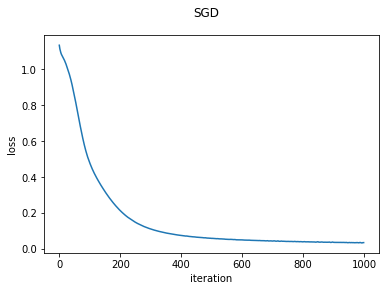

In [0]:
train_sgd_iris(epochs=1000)

K 0,Accuracy: 0.3416666666666667, Loss current:1.1926043296853701 neighbour:3.582847421305875, validation_loss 1.2149014631907145, p_model 0.36787944117144233, p_neighbour 0.049577341372262024, alpha 0.13476518615553068
K 100,Accuracy: 0.5583333333333333, Loss current:2.3417376835356665 neighbour:3.4736419337547733, validation_loss 2.4727351799729758, p_model 0.12657829200321954, p_neighbour 0.04660954376052392, alpha 0.36822699234508866
K 200,Accuracy: 0.5166666666666667, Loss current:2.714793364096598 neighbour:2.748715883353725, validation_loss 2.3053912829256054, p_model 0.08027641889554933, p_neighbour 0.07778580362422072, alpha 0.9689745095060949
K 300,Accuracy: 0.675, Loss current:2.326934501421541 neighbour:11.999396706620871, validation_loss 2.6251462621672546, p_model 0.10272392513778492, p_neighbour 8.006583357873767e-06, alpha 7.794273191113399e-05
K 400,Accuracy: 0.425, Loss current:1.4681152468905965 neighbour:8.79955090705378, validation_loss 1.201380096127654, p_model 0

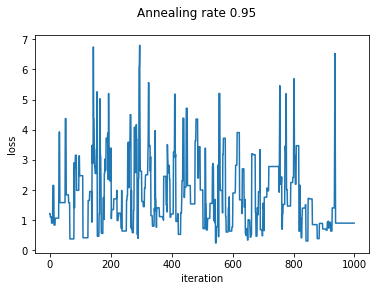

In [0]:
train_sa_iris(k_max = 1000,annealing_rate = 0.95, decay_freq=100)

K 0,Accuracy: 0.3333333333333333, Loss current:1.335454242428144 neighbour:1.8404881657411656, validation_loss 1.3170674781004588, p_model 0.36787944117144233, p_neighbour 0.2520383833582759, alpha 0.6851113575569959
K 100,Accuracy: 0.39166666666666666, Loss current:4.807542539500312 neighbour:1.8693825822438745, validation_loss 3.385542000834488, p_model 0.018317052085853533, p_neighbour 0.21111658555970683, alpha 11.525685714610953
K 200,Accuracy: 0.7583333333333333, Loss current:1.658564163471499 neighbour:2.346931792057997, validation_loss 2.353662879871513, p_model 0.21582905077227327, p_neighbour 0.11421943691235202, alpha 0.5292125249295928
K 300,Accuracy: 0.45, Loss current:3.6777455858368624 neighbour:5.991916758926558, validation_loss 3.8398987306359533, p_model 0.02287570639244247, p_neighbour 0.0021234074511385843, alpha 0.09282368879503114
K 400,Accuracy: 0.6666666666666666, Loss current:4.822675106508238 neighbour:4.283090323504406, validation_loss 4.48159670393652, p_mod

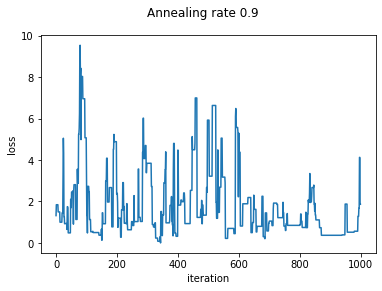

In [0]:
train_sa_iris(k_max = 1000,annealing_rate = 0.90, decay_freq=100)

K 0,Accuracy: 0.3333333333333333, Loss current:1.190190433462461 neighbour:1.3026584486166637, validation_loss 1.2267445663611094, p_model 0.36787944117144233, p_neighbour 0.3347083192888086, alpha 0.9098315421568366
K 100,Accuracy: 0.3333333333333333, Loss current:2.4832168117922264 neighbour:2.7258452837044995, validation_loss 2.4619741938464963, p_model 0.07368148983703694, p_neighbour 0.057107219823211534, alpha 0.7750551726019235
K 200,Accuracy: 0.6666666666666666, Loss current:1.0487162941828576 neighbour:12.120501116980257, validation_loss 1.191319485426478, p_model 0.2523923114677084, p_neighbour 1.2288988067254932e-07, alpha 4.86900254440881e-07
K 300,Accuracy: 0.7416666666666667, Loss current:1.0421353375816882 neighbour:6.079776389422962, validation_loss 1.0623517752896683, p_model 0.1808361712320416, p_neighbour 4.645492902457387e-05, alpha 0.00025688958524212944
K 400,Accuracy: 0.5916666666666667, Loss current:1.1062694366516947 neighbour:7.211496441141446, validation_loss

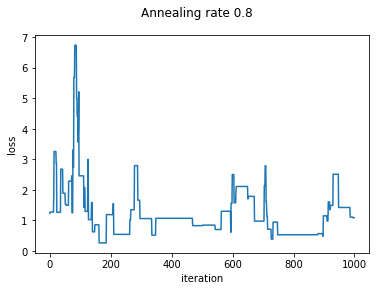

In [0]:
train_sa_iris(k_max = 1000,annealing_rate = 0.80, decay_freq=100)

K 0,Accuracy: 0.3416666666666667, Loss current:1.1489223261674246 neighbour:1.3201296503034732, validation_loss 1.1819266696770987, p_model 0.36787944117144233, p_neighbour 0.3169486271588536, alpha 0.8615556937609526
K 100,Accuracy: 0.30833333333333335, Loss current:2.4527399437502027 neighbour:6.85273190671578, validation_loss 2.1068430906782547, p_model 0.028494909328019607, p_neighbour 4.8168218219106464e-05, alpha 0.001690414861988759
K 200,Accuracy: 0.8083333333333333, Loss current:0.746304404369251 neighbour:2.6764044329557994, validation_loss 0.518771222655414, p_model 0.16457999723037922, p_neighbour 0.0015479731455303371, alpha 0.00940559710523924
K 300,Accuracy: 0.9416666666666667, Loss current:0.13532962564536888 neighbour:3.351808973474711, validation_loss 0.3947064262098498, p_model 0.5796584221285334, p_neighbour 1.3624149784652966e-06, alpha 2.3503755426556967e-06
K 400,Accuracy: 0.825, Loss current:0.3344179309977335 neighbour:5.1872592427974835, validation_loss 0.2945

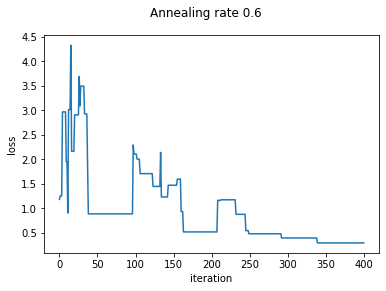

In [0]:
train_sa_iris(k_max = 1000,annealing_rate = 0.60, decay_freq=100)